In [1]:
import harp
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from functools import reduce
import cv2
import numpy as np
import utils
import aeon.io.video as video
import aeon.analysis.movies as frame_helpers
from aeon.io.reader import Reader, Csv
from dotmap import DotMap
import aeon.io.api as aeon
import os

root_folder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/'

h1_reader = harp.create_reader('h1-device.yml', epoch=harp.REFERENCE_EPOCH)
h2_reader = harp.create_reader('h2-device.yml', epoch=harp.REFERENCE_EPOCH)
session_data_reader = utils.SessionData("SessionSettings")
experiment_events_reader = utils.TimestampedCsvReader("ExperimentEvents", columns=["Event"])
framecount_reader = utils.TimestampedCsvReader("OnixAnalogFrameCount", columns=["Index"])
video_reader = utils.Video("VideoData1")

h1_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/HarpDataH1/'
h2_datafolder = r'C:/Users/neurogears/source/repos/vestibular-vr/temp_data/2024-08-23T12-51-05_B3M7/HARP/2024-08-23T12-51-05_B3M7/2024-08-23T12-51-05_B3M7/HarpDataH2/'

In [2]:
# read experiment metadata
session_settings = utils.load(session_data_reader, root_folder)

print(session_settings)

                                                                     metadata
1904-01-06 01:46:41.470240  {'motorSettings': {'nominalPulseInterval': 200...


In [4]:
# read harp streams, experiment events, video
flow_sensor = utils.load_harp(h1_reader.OpticalTrackingRead, h1_datafolder)
analog_input = utils.load_harp(h2_reader.AnalogInput, h2_datafolder)
experiment_events = utils.load(experiment_events_reader, root_folder)
video_data = utils.load(video_reader, root_folder)

print(video_data)

                            HardwareCounter  HardwareTimestamp  FrameIndex  \
Time                                                                         
1904-01-06 01:46:40.899040          2469748    438391022709922           0   
1904-01-06 01:46:40.915712          2469749    438391039382814           1   
1904-01-06 01:46:40.932384          2469750    438391056041220           2   
1904-01-06 01:46:40.949056          2469751    438391072714075           3   
1904-01-06 01:46:40.965728          2469752    438391089372520           4   
...                                     ...                ...         ...   
1904-01-06 02:18:41.463744          2584986    440311572821300       67290   
1904-01-06 02:18:41.480416          2584987    440311589479739       67291   
1904-01-06 02:18:41.497088          2584988    440311606152822       67292   
1904-01-06 02:18:41.513760          2584989    440311622825454       67293   
1904-01-06 02:18:41.530400          2584990    440311639483887  

                                                 Event
Time                                                  
1904-01-06 01:46:48.540256         Sync signal started
1904-01-06 01:47:05.810240  LinearNormal block started
1904-01-06 01:47:05.898144             Homing platform
1904-01-06 01:47:06.470240   Wait for run threshold...
1904-01-06 01:47:27.930688      Check halt probability
...                                                ...
1904-01-06 02:18:30.220256      Check halt probability
1904-01-06 02:18:30.220256              Halt delay: 1s
1904-01-06 02:18:31.240256              Apply halt: 1s
1904-01-06 02:18:32.290240   Wait for run threshold...
1904-01-06 02:18:33.970240         Block timer elapsed

[1240 rows x 1 columns]


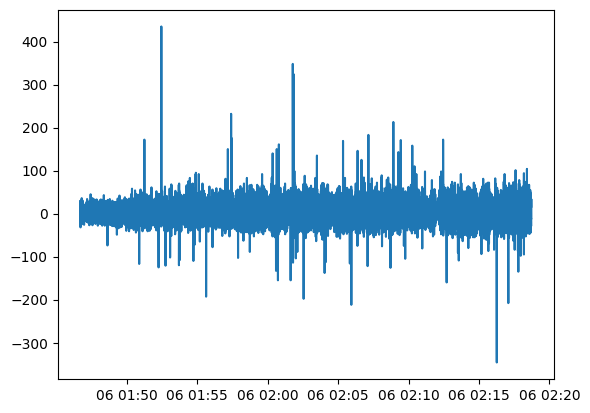

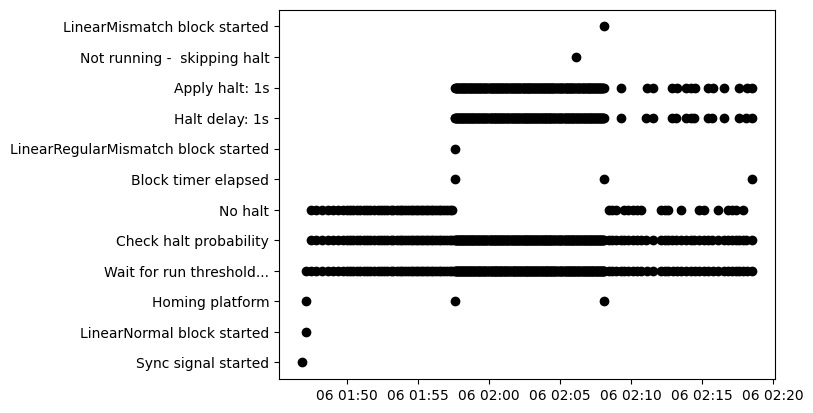

In [5]:
print(experiment_events)

plt.figure()
plt.plot(flow_sensor['OpticalTrackingRead0Y'])

plt.figure()
plt.scatter(experiment_events.index, experiment_events["Event"], c='k')

                              Index
Time                               
1904-01-06 01:46:41.460256        0
1904-01-06 01:46:41.470240        1
1904-01-06 01:46:41.470240        2
1904-01-06 01:46:41.470240        3
1904-01-06 01:46:41.470240        4
...                             ...
1904-01-06 02:18:41.990240  1917257
1904-01-06 02:18:41.990240  1917258
1904-01-06 02:18:41.990240  1917259
1904-01-06 02:18:41.990240  1917260
1904-01-06 02:18:41.990240  1917261

[1917262 rows x 1 columns]


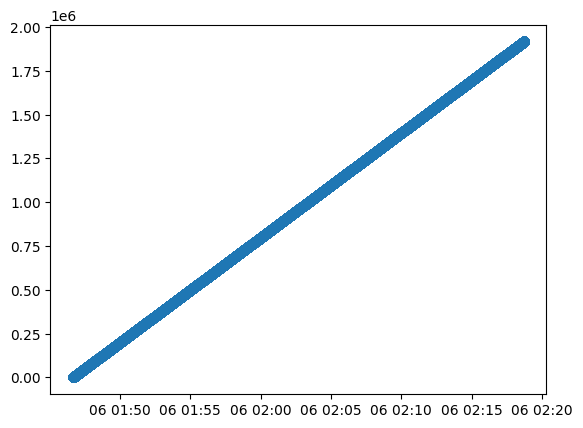

In [4]:
# read onix streams
analog_frame_count = utils.load(framecount_reader, root_folder)
print(analog_frame_count)


plt.scatter(analog_frame_count.index, analog_frame_count["Index"])